# LSTM Shoreline Probe
Kit Calcraft 12-Jan-2024

In [1]:
import numpy as np
import pandas as pd
import os
import yaml
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from functions.load_data import data_select
from functions.LSTM.model import LSTM, CustomMSE
from functions.LSTM.custom_datasets import SequenceDataset
from functions.misc import *
from functions.LSTM import train, predict
from functions.analysis.probe import linearProbe

### 0 - Load Settings & Model Parameters

In [2]:
settings = yaml.safe_load(open("config/model_settings.yml", "r"))
target = settings['target']
batch_size = settings['batch_size']
sequence_length = settings['sequence_length']

### 1 - Select, Split & Standardize Data

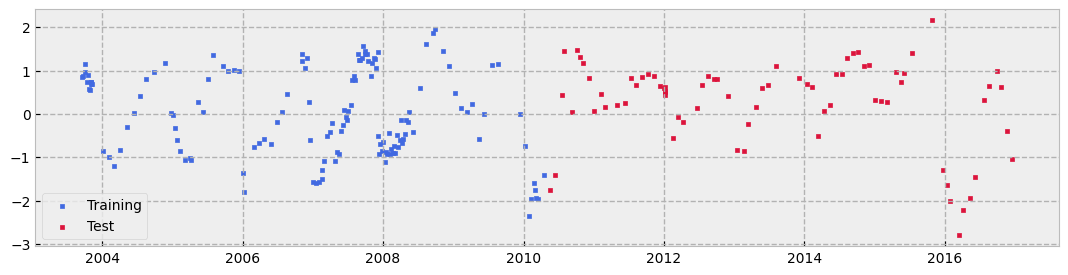

In [3]:
plt.style.use("bmh")
data = data_select(settings)
data.train_test_split()
data.standardize()
plot_train_test(data, settings['shoreline'])

### 2 - Build LSTM Model

In [4]:
train_dataset = SequenceDataset(data.train, data, settings)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_pred = DataLoader(train_dataset, batch_size=1, shuffle=False)

X,y = next(iter(train_loader))
X.shape, y.shape


(torch.Size([20, 1, 2]), torch.Size([20]))

In [5]:
torch.random.seed()
learning_rate, num_hidden_units = float(settings.get('learning_rate')), settings.get('num_hidden_units')
model = LSTM(num_sensors=len(data.features), hidden_units=num_hidden_units, num_layers=settings.get('stacked_lstm_no'))
loss_function = CustomMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
training_start_position = data.df.index.get_loc(data.train.index[0])
_Strength = []

_ , untrained_states = predict.work(data.df, 
                        train_pred, 
                        model, 
                        data.scalers,
                        training_start_position, 
                        settings)

untrained_probeInData = pd.DataFrame(untrained_states)
untrained_probeInData[settings['probe_target']] = data.train.omega_filt.values

init_r2, _ = linearProbe(untrained_probeInData, settings)
_Strength.append(init_r2)
init_r2

0.06589502757802879

### 3 - Train Model

In [7]:
sl_var_name = settings['shoreline']
obs = destandardize(data.train[sl_var_name].values, data.scalers, 'sl')

progress_bar = tqdm(total=settings['epochs'], desc="Probe Strength", unit="epoch")

for epoch in np.arange(settings['epochs']):

    trainloss = train.work(data.df, 
                            data.train, 
                            train_loader, 
                            model, 
                            loss_function, 
                            data.scalers, 
                            optimizer, 
                            settings)

    modelTrain = pd.DataFrame()

    training_start_position = data.df.index.get_loc(data.train.index[0])
    modelTrain['shoreline'], current_state = predict.work(data.df, 
                                                            train_pred, 
                                                            model, 
                                                            data.scalers,
                                                            training_start_position, 
                                                            settings)
    
    # ############### Probe

    int_probeInData = pd.DataFrame(current_state)
    int_probeInData[settings['probe_target']] = data.train.omega_filt.values
    r2, _ = linearProbe(int_probeInData, settings)
    _Strength.append(r2)

    progress_bar.set_description(f"Probe Strength: {r2:.3f}")
    progress_bar.update()
    
progress_bar.close()

Probe Strength: 0.747: 100%|██████████| 25/25 [00:35<00:00,  1.44s/epoch]


Text(0.5, 0, 'Epoch')

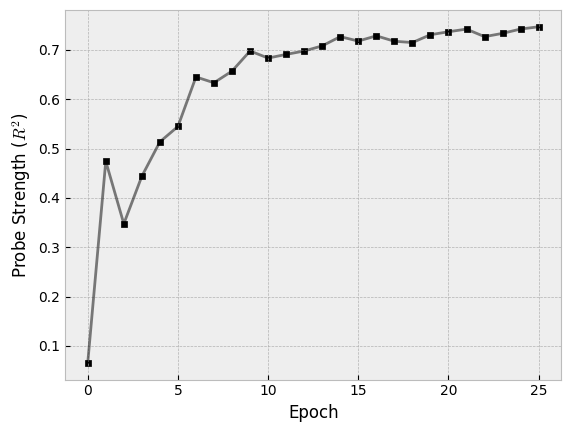

In [8]:
S_curve = pd.DataFrame(_Strength, columns = [settings['case']])

plt.plot(S_curve.index, S_curve, c = 'k', alpha = 0.5)
plt.scatter(S_curve.index, S_curve, s = 20, marker = 's',c = 'k')
plt.ylabel('Probe Strength ($R^2$)')
plt.xlabel('Epoch')

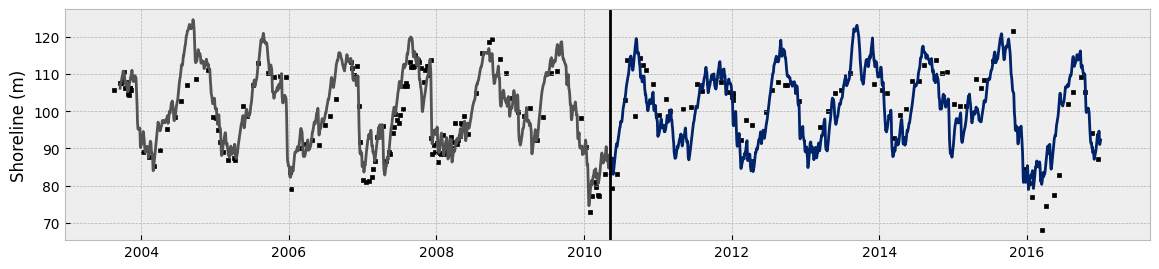

In [9]:
shoreline = destandardize(data.df[sl_var_name],data.scalers,'sl')
training_start_position = data.df.index.get_loc(data.train.index[0])
test_start_date = data.test.index[0]

modelTrain = pd.DataFrame()
modelTest = pd.DataFrame()

test_dataset = SequenceDataset(data.test, data, settings)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

modelTrain['model_output'], trained_c = predict.work(data.df, 
                        train_loader, 
                        model, 
                        data.scalers,
                        training_start_position, 
                        settings)

modelTest['model_output'], test_c = predict.work(data.df, 
                            test_loader, 
                            model, 
                            data.scalers,
                            test_start_date, 
                            settings)

modelTest.index = data.test.index
modelTrain.index = data.train.index
plt.figure(figsize=(14, 3))
plt.scatter(data.df.index,shoreline, marker="s", s = 10, c = 'k')
plt.plot(modelTrain.model_output, label = 'Training', c = '#535353')
plt.plot(modelTest.model_output,label = 'Test' , c = '#00236A')
plt.axvline(modelTest.index[0], c = 'k')
plt.ylabel('Shoreline (m)');

In [10]:
trained_probeInData = pd.DataFrame(trained_c)
trained_probeInData[settings['probe_target']] = data.train.omega_filt.values
trained_probeInData['omega_filt'] = trained_probeInData['omega_filt'].sample(frac=1).values
shuffled_r2, trained_probe = linearProbe(trained_probeInData, settings)

print(
f'''
Probe Strength: {r2}
selectivity: {r2 - shuffled_r2 }
ΔR2: {r2 - init_r2}
''')


Probe Strength: 0.7467559246804762
selectivity: 0.7449386503787178
ΔR2: 0.6808608971024475

